## Backprojetion from triangulation

In [2]:
# import necessary modules
import matplotlib.pyplot as plt
import numpy as np

import multicam_calibration as mcc
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import plotly.express as px
import pickle

In [3]:
from threed_utils.visualization import plot_triangulations, plot_back_projections
from threed_utils.old_triangulation import back_project_points
from utils import read_first_frame

### get triangulation from predictions: mcc, anipose

In [4]:
# get data from one session:
from pathlib import Path
dir_path = Path(r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\20240724\100455\multicam_video_2024-07-24T10_20_07_cropped_20241209165236")
calibration_path = Path(r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\20240724\calibration\multicam_video_2024-07-24T14_13_45_cropped_20241209165236")

### Get calibration matrices

In [4]:
data_dir = Path('/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/calibration')

In [5]:
# get the matrices:

from threed_utils.io import movement_ds_from_anipose_triangulation_df, read_calibration_toml


In [6]:
calibration_paths = sorted(data_dir.glob("mc_calibration_output_*"))
last_calibration_path = calibration_paths[-1]

all_calib_uvs = np.load(last_calibration_path / "all_calib_uvs.npy")
calib_toml_path = last_calibration_path / "calibration_from_mc.toml"
print(calib_toml_path)
cam_names, img_sizes, extrinsics, intrinsics = read_calibration_toml(calib_toml_path)

/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/calibration/mc_calibration_output_20241210-164414/calibration_from_mc.toml


In [7]:
# get triangulated points from both: 
import xarray as xr

slp_dir = Path('/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/video_test')

triangulation_path = slp_dir / 'anipose_triangulated_ds.h5'
mcc_path = slp_dir / 'mcc_triangulated_ds.h5'
anipose_ds = xr.open_dataset(triangulation_path)
mcc_ds = xr.open_dataset(mcc_path)


In [8]:
mcc_ds.info

<bound method Dataset.info of <xarray.Dataset> Size: 421kB
Dimensions:      (time: 1001, keypoints: 13, individuals: 1, space: 3)
Coordinates:
  * time         (time) int32 4kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999 1000
  * keypoints    (keypoints) object 104B 'blimbmid' 'flimbmid' ... 'uppermid'
  * space        (space) object 24B 'x' 'y' 'z'
  * individuals  (individuals) object 8B 'individual_0'
Data variables:
    confidence   (time, keypoints, individuals) float64 104kB ...
    position     (time, space, keypoints, individuals) float64 312kB ...
Attributes:
    fps:              fps
    time_unit:        frames
    source_software:  SLEAP_triangulated
    source_file:      mcc
    ds_type:          poses>

In [9]:
arena_path = '/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/3d-setup/tests/assets/arena_tracked_points.pkl'
with open(arena_path, 'rb') as f:
    arena_points = pickle.load(f)

## Utility Functions 

How to get store indices from original video to xarray?

In [95]:
def get_3d_arena(arena_path, extrinsics, intrinsics):
    with open(arena_path, 'rb') as f:
        points = pickle.load(f)
    arena_points = points['points']['arena_coordinates'].squeeze()

    arena_3d = mcc.triangulate(arena_points[..., [1, 0]], extrinsics, intrinsics)
    return arena_3d.reshape((8, 1, 3))


In [102]:
def backproject_triangulated_points(xarray_ds, extrinsics, intrinsics, frame_n, cam_names, arena_3d):
    """
    Back-project 3D triangulated points to 2D camera coordinates for a specific frame.
    
    Args:
        xarray_ds (xarray.Dataset): Dataset containing triangulated points with dimensions:
            (time: 1001, keypoints: 13, individuals: 1, space: 3)
        extrinsics (list): List of extrinsic matrices for each camera
        intrinsics (list): List of intrinsic matrices for each camera
        frame_n (int): Frame number to process
        
    Returns:
        dict: Dictionary of back-projected points for each camera
    """
    video_paths = sorted(slp_dir.glob("*.mp4"))

    camera_matrices = [i[0] for i in intrinsics]
    # Extract 3D points for the specified frame
    # Shape will be (space, keypoints, individuals)
    frame_points = mcc_ds.position.isel(time=frame_n).values.transpose(1, 2, 0)

     # Now shape is (keypoints, space)
    
    # Initialize dictionary to store back-projected points for each camera

    arena2d = mcc.project_points(arena_3d, extrinsics, camera_matrices)

    back_projected = mcc.project_points(frame_points, extrinsics, camera_matrices)

    back_projected_points = {camera: [points, arena] for camera, points, arena in zip(cam_names, back_projected, arena2d)}
    
    
    return back_projected_points, frame_points

In [73]:
import cv2

def read_nth_frame(input_file, n):
    """
    Reads the nth frame from the input video file.

    Args:
        input_file (str or Path): Path to the video file.
        n (int): Frame number to read (0-indexed).

    Returns:
        np.ndarray: The nth frame as an image array.

    Raises:
        ValueError: If the frame cannot be read or the frame number is out of bounds.
    """
    # Open the video file
    cap = cv2.VideoCapture(str(input_file))
    
    # Check if the video was successfully opened
    if not cap.isOpened():
        raise ValueError(f"Failed to open the video file: {input_file}")
    
    # Set the frame position
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if n < 0 or n >= total_frames:
        cap.release()
        raise ValueError(f"Frame number {n} is out of bounds for video with {total_frames} frames.")
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, n)
    
    # Read the frame
    ret, frame = cap.read()
    if not ret:
        cap.release()
        raise ValueError(f"Failed to read frame {n} from the video.")
    
    # Release the video capture object
    cap.release()
    
    return frame

In [74]:
import re

def get_frames_camera(backprojections, n_frame, video_dir):
    """
    Associates video frames with their corresponding camera keys from backprojections.

    Args:
        backprojections (dict): Dictionary where keys are camera names (e.g., 'mirror-left')
                                and values are backprojected points.
        n_frame (int): Frame number to extract.
        video_dir (Path): Directory containing the video files.

    Returns:
        dict: Dictionary with keys as camera names and values as tuples:
              (frame from video, backprojected points).
    """
    backprojections_frames = {}
    video_paths = sorted(video_dir.glob("*.mp4"))

    # Regex to extract camera name from video file names
    camera_name_regex = re.compile(r".*_(\w+(?:-\w+)?)\.avi\.mp4$")

    # Create a map of camera name to video path
    video_camera_map = {}
    for video_path in video_paths:
        match = camera_name_regex.match(video_path.name)
        if match:
            camera_name = match.group(1)
            video_camera_map[camera_name] = video_path
        else:
            raise ValueError(f"Could not extract camera name from: {video_path.name}")

    # Match backprojection keys to their corresponding video and extract frames
    for camera, points in backprojections.items():
        if camera in video_camera_map:
            video_path = video_camera_map[camera]
            backprojections_frames[camera] = (read_nth_frame(video_path, n_frame), points)
        else:
            raise KeyError(f"Camera '{camera}' not found in video files.")
    
    return backprojections_frames


In [108]:


def plot_frames_with_points(camera_data):
    """
    Plots frames with tracked points in subplots, using camera names as titles.

    Args:
        camera_data (dict): A dictionary where keys are camera names and values are tuples:
                            (frame (numpy array), tracked points (list or numpy array)).
    """
    # Determine the number of subplots needed
    n_cameras = len(camera_data)
    n_cols = 3  # Number of columns in the grid
    n_rows = -(-n_cameras // n_cols)  # Ceiling division to get rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    # Flatten axes for easy iteration
    axes = axes.flatten() if n_rows > 1 else [axes]
    
    # Loop over cameras and plot data
    for idx, (camera_name, (frame, points)) in enumerate(camera_data.items()):
        ax = axes[idx]
        ax.imshow(frame)  # Display the frame
        points = np.array(points)  # Ensure points are in array form
        if len(points) > 0:
            ax.scatter(points[0][:, 0], points[0][:, 1], color='red', s=10)
            ax.scatter(points[1][:, 0], points[1][:, 1], color='blue', s=10)  # Plot points
        ax.set_title(camera_name)
        ax.axis('off')  # Turn off axis for a cleaner look

    # Hide unused subplots
    for i in range(len(camera_data), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()



In [104]:
import plotly.graph_objects as go
def plot3d_frame(frame_points3d, arena_3d):
    frame_points3d = frame_points3d.squeeze()
    arena_3d = arena_3d.squeeze()
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=frame_points3d[:, 0], y=frame_points3d[:, 1], z=frame_points3d[:, 2], mode='markers', marker=dict(size=5, color='red')))
    #add arena points 
    fig.add_trace(go.Scatter3d(x=arena_3d[:, 0], y=arena_3d[:, 1], z=arena_3d[:, 2], mode='markers', marker=dict(size=5, color='blue')))
    fig.show()


## Final Function

In [115]:
# function that combines the previous functions into a single one by calling them:

def backprojections_plots(ds, n_frame, video_dir, calibration_dir, arena_path):


    # load the calibration matrices:
    calibration_path = Path(calibration_dir)
    calibration_paths = sorted(data_dir.glob("mc_calibration_output_*"))
    last_calibration_path = calibration_paths[-1]

    all_calib_uvs = np.load(last_calibration_path / "all_calib_uvs.npy")
    calib_toml_path = last_calibration_path / "calibration_from_mc.toml"
    print(calib_toml_path)
    cam_names, img_sizes, extrinsics, intrinsics = read_calibration_toml(calib_toml_path)


    arena_3d = get_3d_arena(arena_path, extrinsics, intrinsics)

    backprojections, frame_points3d = backproject_triangulated_points(ds, extrinsics, intrinsics, n_frame, cam_names, arena_3d)
    plot3d_frame(frame_points3d, arena_3d)

    cam_frame_points = get_frames_camera(backprojections, n_frame, video_dir)


    plot_frames_with_points(cam_frame_points)


/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/calibration/mc_calibration_output_20241210-164414/calibration_from_mc.toml


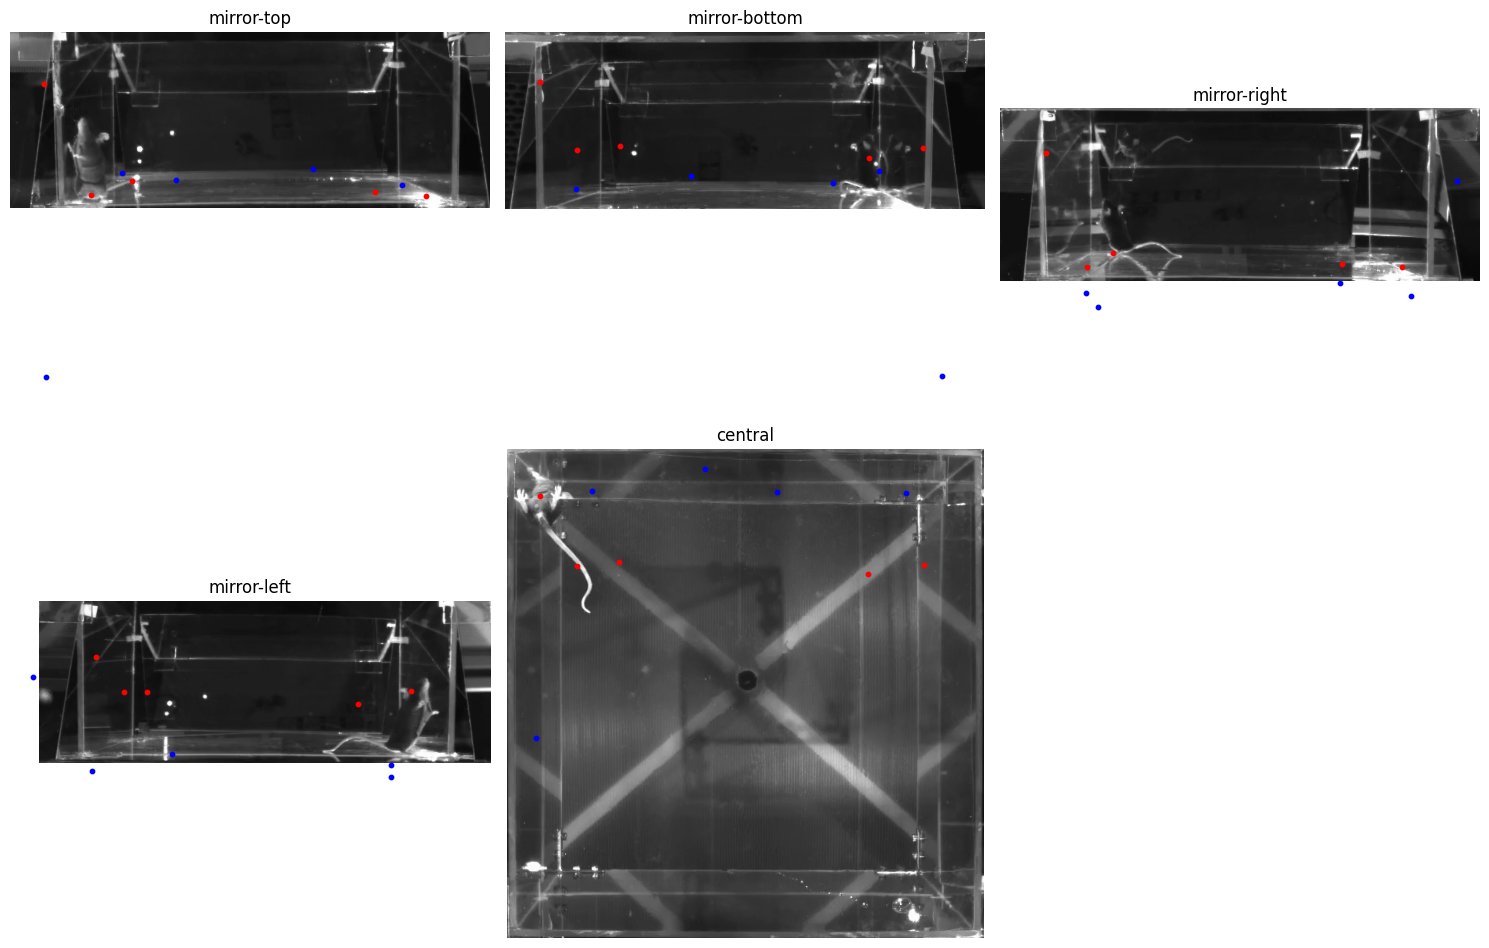

In [117]:
calibration_path = '/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/calibration'
backprojections_plots(anipose_ds, 350, slp_dir, calibration_path, arena_path)